**HYBRID** **TASK**

In [2]:
import pandas as pd

df = pd.read_csv("/content/data.csv", encoding='ISO-8859-1')

**DATA ANALYSING AND PROCESSING**

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Remove missing CustomerID and cancellations (InvoiceNo starting with 'C')
df = df[df['CustomerID'].notnull()]
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [5]:
# Reference date: max InvoiceDate + 1
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'UnitPrice': lambda x: (x * df.loc[x.index, 'Quantity']).sum()  # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'UnitPrice': 'Monetary'
})

In [16]:
rfm.head()
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4339 entries, 12346.0 to 18287.0
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Recency    4339 non-null   int64   
 1   Frequency  4339 non-null   int64   
 2   Monetary   4339 non-null   float64 
 3   Cluster    4339 non-null   int32   
 4   Segment    4339 non-null   object  
 5   R_Score    4339 non-null   category
 6   F_Score    4339 non-null   category
 7   M_Score    4339 non-null   category
 8   RFM_Score  4339 non-null   int64   
dtypes: category(3), float64(1), int32(1), int64(3), object(1)
memory usage: 233.6+ KB


In [18]:
rfm.shape

(4339, 9)

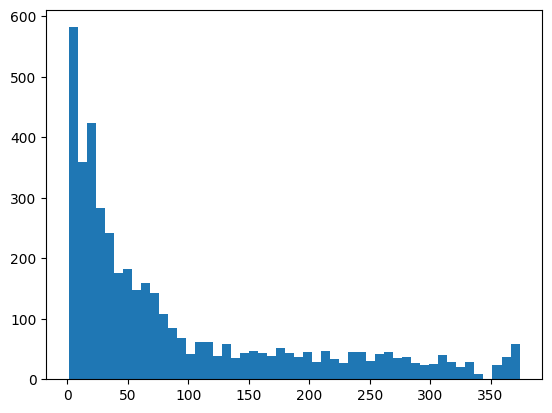

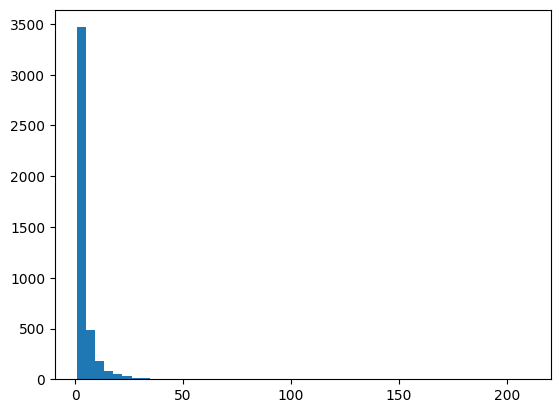

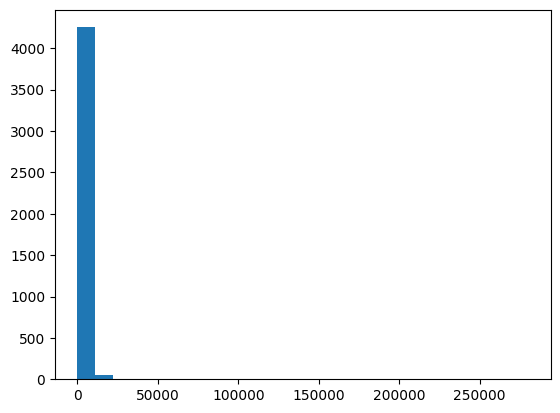

In [7]:
import matplotlib.pyplot as plt
plt.hist(rfm['Recency'],bins=50)
plt.show()
plt.hist(rfm['Frequency'],bins=50)
plt.show()
plt.hist(rfm['Monetary'],bins=25)
plt.show()

**CLUSTERING OF DATA**

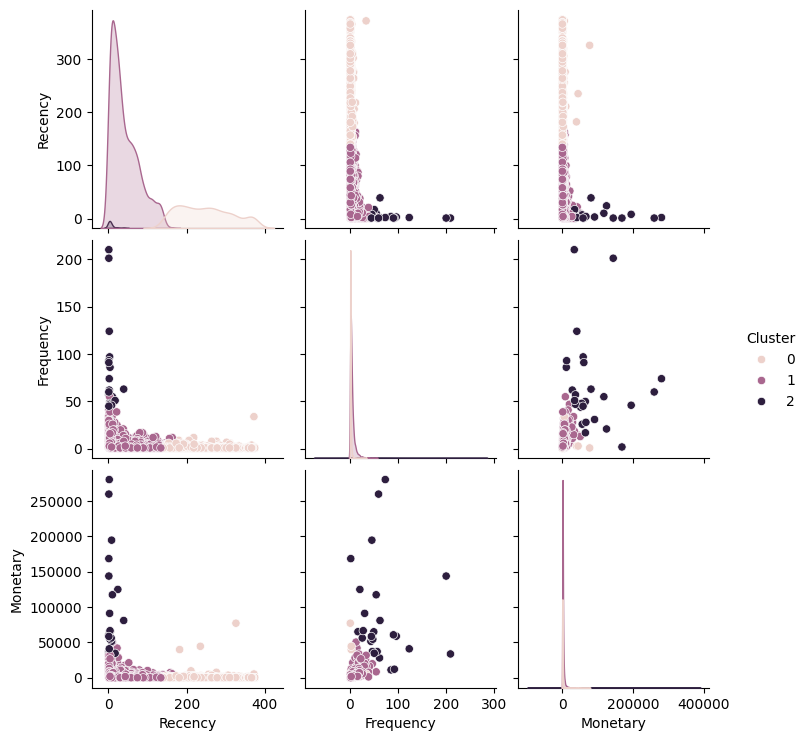

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Normalize RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# KMeans clustering (k=3)
kmeans = KMeans(n_clusters=3, random_state=1)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualize clusters
sns.pairplot(rfm, hue='Cluster', vars=['Recency', 'Frequency', 'Monetary'])
plt.show()


In [9]:
rfm['Cluster'].value_counts().sort_index()


,count
Cluster,
0,1082
1,3231
2,26


**Now clearly from the scatter chart we can see that class 2 belongs to the platinum category class 1 belongs to gold and class 0 to the silver based on monetary, frequency and recency performance**

In [12]:
# Define mapping dictionary
label_map = {2: 'Platinum', 1: 'Gold', 0: 'Silver'}

# Apply it to create a new column
rfm['Segment'] = rfm['Cluster'].map(label_map)


In [14]:
rfm['Segment'].value_counts().sort_index()

,count
Segment,
Gold,3231
Platinum,26
Silver,1082


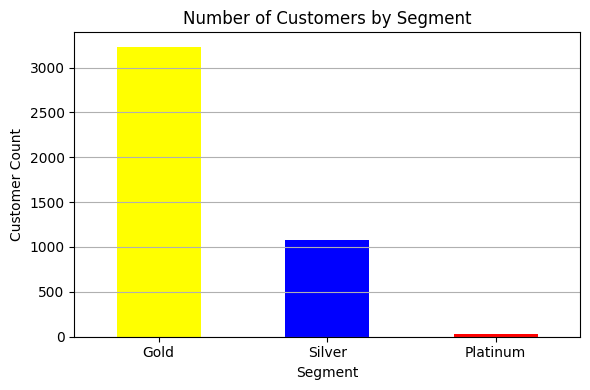

In [29]:
plt.figure(figsize=(6,4))
segment_counts = rfm['Segment'].value_counts()
segment_counts.plot(kind='bar', color=['yellow', 'blue', 'red'])
plt.title("Number of Customers by Segment")
plt.ylabel("Customer Count")
plt.xlabel("Segment")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


**DIVIDING IN QUANTILES AND INSIGHTS**

In [35]:
# Create quantile-based scores
rfm['R_score'] = pd.qcut(rfm['Recency'], q=4, labels=[4, 3, 2, 1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=[1, 2, 3, 4])
rfm['M_score'] = pd.qcut(rfm['Monetary'], q=4, labels=[1, 2, 3, 4])

rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int).sum(axis=1)


In [23]:
# Top customers
top_customers = rfm.sort_values(by='RFM_Score', ascending=False).head(10)

# Loyal customers: High Frequency
loyal_customers = rfm.sort_values(by='Frequency', ascending=False).head(10)

# Big spenders: High Monetary
big_spenders = rfm.sort_values(by='Monetary', ascending=False).head(10)

TOP CUSTOMERS

In [26]:
top_customers

,Recency,Frequency,Monetary,Cluster,Segment,R_Score,F_Score,M_Score,RFM_Score
CustomerID,,,,,,,,,
18283.0,4,16,2094.88,1,Gold,4,4,4,12
12362.0,3,10,5226.23,1,Gold,4,4,4,12
15514.0,12,11,4139.46,1,Gold,4,4,4,12
14062.0,10,12,10464.85,1,Gold,4,4,4,12
14060.0,5,19,6140.42,1,Gold,4,4,4,12
18180.0,5,6,1843.75,1,Gold,4,4,4,12
18179.0,9,6,1793.17,1,Gold,4,4,4,12
12423.0,1,8,1859.31,1,Gold,4,4,4,12
12417.0,3,9,3649.10,1,Gold,4,4,4,12


FREQUENT CUSTOMERS

In [27]:
loyal_customers

,Recency,Frequency,Monetary,Cluster,Segment,R_Score,F_Score,M_Score,RFM_Score
CustomerID,,,,,,,,,
12347.0,2,7,4310.00,1,Gold,4,4,4,12
12352.0,36,8,2506.04,1,Gold,3,4,4,11
12362.0,3,10,5226.23,1,Gold,4,4,4,12
12388.0,16,6,2780.66,1,Gold,4,4,4,12
12395.0,19,12,3018.63,1,Gold,3,4,4,11
...,...,...,...,...,...,...,...,...,...
18245.0,7,7,2567.06,1,Gold,4,4,4,12
18257.0,39,8,2337.63,1,Gold,3,4,4,11
18260.0,173,6,2643.20,0,Silver,1,4,4,9


BIG SPENDERS

In [28]:
big_spenders

,Recency,Frequency,Monetary,Cluster,Segment,R_Score,F_Score,M_Score,RFM_Score
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,0,Silver,1,1,4,6
12347.0,2,7,4310.00,1,Gold,4,4,4,12
12348.0,75,4,1797.24,1,Gold,2,3,4,9
12349.0,19,1,1757.55,1,Gold,3,1,4,8
12352.0,36,8,2506.04,1,Gold,3,4,4,11
...,...,...,...,...,...,...,...,...,...
18259.0,25,3,2338.60,1,Gold,3,3,4,10
18260.0,173,6,2643.20,0,Silver,1,4,4,9
18272.0,3,6,3078.58,1,Gold,4,4,4,12


OTHER INSIGHTS

In [37]:
df['Revenue'] = df['Quantity'] * df['UnitPrice']#Money generated per product
most_revenue = df.groupby('Country')['Revenue'].sum().sort_values(ascending=False)
print("Country with highest total revenue:\n", most_revenue.head(1))


Country with highest total revenue:
 Country
United Kingdom    7308391.554
Name: Revenue, dtype: float64


In [38]:
top_items = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(5)
print("Top 5 Most Sold Items (by Quantity):\n", top_items)


Top 5 Most Sold Items (by Quantity):
 Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS     54415
JUMBO BAG RED RETROSPOT               46181
WHITE HANGING HEART T-LIGHT HOLDER    36725
Name: Quantity, dtype: int64


In [39]:
most_revenue_per_product = df.groupby('Description')['Revenue'].sum().sort_values(ascending=False)
print("Country with highest total revenue:\n", most_revenue_per_product.head(5))


Country with highest total revenue:
 Description
PAPER CRAFT , LITTLE BIRDIE           168469.60
REGENCY CAKESTAND 3 TIER              142592.95
WHITE HANGING HEART T-LIGHT HOLDER    100448.15
JUMBO BAG RED RETROSPOT                85220.78
MEDIUM CERAMIC TOP STORAGE JAR         81416.73
Name: Revenue, dtype: float64
